__To Do List for Data Scientists__

+ How many patients have echo in first 48hour of ICU hospitalization? 
+ What is the distribution of echoes by hospitalization day? 
+ How many patients have outpatient pre-hospitalization echo and ICU hospitalization echo? 
+ We need to create two new variables: 
    1. Decrement in EF 
    2. Time difference between the two echoes
+ How many patients have post-hospitalization echo. Also need the delta in EF and time difference variables. Graphical distribution of duration and decrement/increment in EF
+ Summary statistics (descriptive) for all people with echo:
    1. how many people were on dialysis 
    2. how many people were on ventilator 
    3. what were the different diagnoses for ICU admission 
    4. average ICU length of stay 
    5. mortality in ICU 
    6. mortality in hospital 
    7. 30 day mortality 
    8. how many people carry a diagnosis of heart failure 
    9. number of secondary diagnosis 
    10. age and gender distribution 
    11. How many people had a BNP or NTproBNP sent?
    12. How many people had a troponin-I or troponin-T sent? 
    13. Number of people with valvular heart disease that is moderate or above
+ Also since kidney function will be a crucial element of our analysis of ejection function and fluid management, we need to better understand their kidney function. Please pull out distribution of: 
    1. baseline Creatinine (Cr) prior to the admission. 
    2. ICU Cr on the day of the echo 
    3. Cr measurement post ICU discharge

In [2]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [266]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

## Number of patients with echos within 48 hours of ICU hospitalization

Echos are associated with hadm_ids (hospital admission ids) and not to icustay_ids (ICU stay ids). Echos however have a time stamp within the report. Here, associate each echo report to an ICU stay by cross-referencing the echos vs. icustays using hadm_ids, and then selecting the ICU stay during which the echo was done. 

In [260]:
query = \
"""
WITH echos AS (
-- parse echo report to get echo_time
    SELECT hadm_id, row_id, subject_id, text,
    -- timestamp for echo
    to_timestamp(
        regexp_replace(regexp_replace(regexp_replace(
            substring(text from 'Date/Time:.*?\n'), 
            'Date/Time: ...', ''), '... at', ''), '\n', ''), 
        'YYYY-MM-DD HH24:MI')::timestamp without time zone AS echo_time  
    FROM noteevents
    WHERE category = 'Echo'), 
-- merge with icustays, get icustay timestamps, and calculate timedeltas wrt echo_time    
    this_echo AS (
    SELECT ec.hadm_id, ec.row_id, ec.subject_id, ec.echo_time, ec.text,
        ie.intime, ie.outtime, ie.icustay_id,
        ps.dob::date, ps.dod::date, ps.gender,
        am.dischtime, 
        CASE 
        WHEN ((ec.echo_time > ie.intime) AND 
            (ec.echo_time < ie.outtime)) 
        THEN 1 ELSE 0 END AS this_icu, 
        ec.echo_time - ie.intime AS time_to_echo,
        -- age in years
        extract(year from age(ec.echo_time::date, ps.dob)) AS age 
    FROM echos ec
    INNER JOIN icustays ie
        ON ie.hadm_id = ec.hadm_id
    INNER JOIN patients ps
        ON ie.subject_id = ps.subject_id
    INNER JOIN admissions am
        ON ie.hadm_id = am.hadm_id)
SELECT * 
FROM this_echo
WHERE this_icu = 1
"""

icu_echos = pd.read_sql_query(query, con)
icu_echos.head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,dob,dod,gender,dischtime,this_icu,time_to_echo,age
0,179179,77947,52590,2118-09-02 13:39:00,PATIENT/TEST INFORMATION:\nIndication: intraop...,2118-09-02 11:18:44,2118-09-03 17:43:25,241967,2042-09-29,None,M,2118-09-06 13:18:00,1,0 days 02:20:16,75.0
1,114624,77949,18040,2185-03-24 14:00:00,PATIENT/TEST INFORMATION:\nIndication: Congeni...,2185-01-27 16:15:51,2185-05-23 16:23:59,212314,2185-01-27,None,F,2185-05-23 15:30:00,1,55 days 21:44:09,0.0
2,114624,77950,18040,2185-03-23 15:00:00,PATIENT/TEST INFORMATION:\nIndication: Congeni...,2185-01-27 16:15:51,2185-05-23 16:23:59,212314,2185-01-27,None,F,2185-05-23 15:30:00,1,54 days 22:44:09,0.0
3,114624,77951,18040,2185-03-18 15:00:00,PATIENT/TEST INFORMATION:\nIndication: Congeni...,2185-01-27 16:15:51,2185-05-23 16:23:59,212314,2185-01-27,None,F,2185-05-23 15:30:00,1,49 days 22:44:09,0.0
4,191596,78276,538,2161-10-29 18:57:00,PATIENT/TEST INFORMATION:\nIndication: Pericar...,2161-10-28 15:02:15,2161-11-01 17:45:26,293509,2088-12-05,2161-12-20,F,2161-11-16 18:45:00,1,1 days 03:54:45,72.0


In [164]:
icu_echos.shape

(22169, 14)

Of the echos which are associated to an ICU stay, how many were done within 48 hours of admission to the ICU? 

In [165]:
(icu_echos['time_to_echo'] < pd.Timedelta(hours = 48)).value_counts()

True     15468
False     6701
Name: time_to_echo, dtype: int64

## Number of patients with echos who also have sepsis

Using the code available from the repo to get hadm_id -> sepsis

In [166]:
query = \
"""
-- ICD-9 codes for Angus criteria of sepsis

-- Angus et al, 2001. Epidemiology of severe sepsis in the United States
-- http://www.ncbi.nlm.nih.gov/pubmed/11445675

-- Case selection and definitions
-- To identify cases with severe sepsis, we selected all acute care
-- hospitalizations with ICD-9-CM codes for both:
-- (a) a bacterial or fungal infectious process AND
-- (b) a diagnosis of acute organ dysfunction (Appendix 2).

-- Appendix 1: ICD9-codes (infection)

WITH infection_group AS (
    SELECT subject_id, hadm_id,
    CASE
        WHEN substring(icd9_code,1,3) IN ('001','002','003','004','005','008',
               '009','010','011','012','013','014','015','016','017','018',
               '020','021','022','023','024','025','026','027','030','031',
               '032','033','034','035','036','037','038','039','040','041',
               '090','091','092','093','094','095','096','097','098','100',
               '101','102','103','104','110','111','112','114','115','116',
               '117','118','320','322','324','325','420','421','451','461',
               '462','463','464','465','481','482','485','486','494','510',
               '513','540','541','542','566','567','590','597','601','614',
               '615','616','681','682','683','686','730') THEN 1
        WHEN substring(icd9_code,1,4) IN ('5695','5720','5721','5750','5990','7110',
                '7907','9966','9985','9993') THEN 1
        WHEN substring(icd9_code,1,5) IN ('49121','56201','56203','56211','56213',
                '56983') THEN 1
        ELSE 0 END AS infection
    FROM MIMICIII.DIAGNOSES_ICD),
-- Appendix 2: ICD9-codes (organ dysfunction)
    organ_diag_group as (
    SELECT subject_id, hadm_id,
        CASE
        -- Acute Organ Dysfunction Diagnosis Codes
        WHEN substring(icd9_code,1,3) IN ('458','293','570','584') THEN 1
        WHEN substring(icd9_code,1,4) IN ('7855','3483','3481',
                '2874','2875','2869','2866','5734')  THEN 1
        ELSE 0 END AS organ_dysfunction,
        -- Explicit diagnosis of severe sepsis or septic shock
        CASE
        WHEN substring(icd9_code,1,5) IN ('99592','78552')  THEN 1
        ELSE 0 END AS explicit_sepsis
    FROM MIMICIII.DIAGNOSES_ICD),

-- Mechanical ventilation
    organ_proc_group as (
    SELECT subject_id, hadm_id,
        CASE
        WHEN substring(icd9_code,1,4) IN ('9670','9671','9672') THEN 1
        ELSE 0 END AS mech_vent
    FROM MIMICIII.PROCEDURES_ICD),

-- Aggregate
    aggregate as (
    SELECT subject_id, hadm_id,
        CASE
        WHEN hadm_id in (SELECT DISTINCT hadm_id
                FROM infection_group
                WHERE infection = 1) THEN 1
            ELSE 0 END AS infection,
        CASE
        WHEN hadm_id in (SELECT DISTINCT hadm_id
                FROM organ_diag_group
                WHERE explicit_sepsis = 1) THEN 1
            ELSE 0 END AS explicit_sepsis,
        CASE
        WHEN hadm_id in (SELECT DISTINCT hadm_id
                FROM organ_diag_group
                WHERE organ_dysfunction = 1) THEN 1
            ELSE 0 END AS organ_dysfunction,
        CASE
        WHEN hadm_id in (SELECT DISTINCT hadm_id
                FROM organ_proc_group
                WHERE mech_vent = 1) THEN 1
            ELSE 0 END AS mech_vent
    FROM MIMICIII.ADMISSIONS)
-- List angus score for each admission
SELECT subject_id, hadm_id, infection,
       explicit_sepsis, organ_dysfunction, mech_vent,
    CASE
    WHEN explicit_sepsis = 1 THEN 1
    WHEN infection = 1 AND organ_dysfunction = 1 THEN 1
    WHEN infection = 1 AND mech_vent = 1 THEN 1
    ELSE 0 END AS Angus
FROM aggregate;

"""

angus = pd.read_sql_query(query, con)
angus.head()

,subject_id,hadm_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus
0,22,165315,0,0,0,1,0
1,23,152223,0,0,0,0,0
2,23,124321,0,0,0,0,0
3,24,161859,0,0,0,0,0
4,25,129635,0,0,0,0,0


In [167]:
len(set(angus.loc[angus['angus'] == 1, 'hadm_id']) & 
    set(icu_echos['hadm_id']))

7091

Echo report also has indication. 

## Distribution of number of echos by hospitalization day

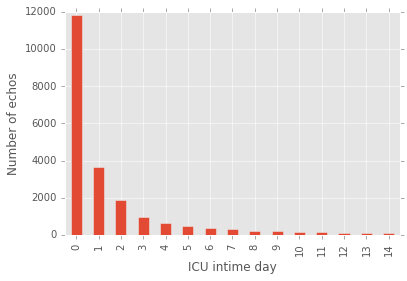

In [168]:
icu_echos['time_to_echo'].apply(lambda dt: dt.days).value_counts().sort_index().plot(kind = 'bar')
_ = plt.xlim([-0.5, 14.5])
plt.xlabel('ICU intime day')
plt.ylabel('Number of echos')

## Number of patients with outpatient pre-hospitalization echo and ICU hospitalization echo

+ Echo reports have a status which is either Inpatient or Outpatient
+ Some echos also don't have hadm_ids, and are presumably outpatient

In [169]:
query = \
"""
WITH this_echo AS (
    SELECT row_id, hadm_id, subject_id,
        regexp_replace(regexp_replace(substring(text, 'Status:.+?\n'), 'Status: ', ''), '\n', '') AS echo_status, 
        to_timestamp(
        regexp_replace(regexp_replace(regexp_replace(
            substring(text from 'Date/Time:.*?\n'), 
            'Date/Time: ...', ''), '... at', ''), '\n', ''), 
        'YYYY-MM-DD HH24:MI')::timestamp without time zone AS echo_time  
    FROM noteevents
    WHERE category = 'Echo'
)
SELECT * FROM this_echo
WHERE echo_status = 'Outpatient';
"""

outpatient_echos = pd.read_sql_query(query, con)
outpatient_echos = outpatient_echos.loc[outpatient_echos['hadm_id'].isnull()] 
outpatient_echos.head()

,row_id,hadm_id,subject_id,echo_status,echo_time
0,77922,NaN,7949,Outpatient,2124-08-31 14:00:00
1,78193,NaN,25929,Outpatient,2201-06-04 13:42:00
2,78194,NaN,25929,Outpatient,2200-05-14 11:00:00
6,77565,NaN,12556,Outpatient,2164-08-06 10:00:00
9,77768,NaN,51754,Outpatient,2101-07-04 14:00:00


Count the number of patients where the timestamp on the outpatient echo is EARLIER than the EARLIEST ICU echo. 

In [170]:
res = icu_echos.sort_values('echo_time').groupby('subject_id').first().reset_index().merge(
    outpatient_echos, left_on = 'subject_id', right_on = 'subject_id', 
    suffixes = ['.icu', '.outpatient']
)
# number of patients where the timestamp on the outpatient echo is earlier than the earliest icu echo
(res['echo_time.outpatient'] < res['echo_time.icu']).value_counts()

False    2480
True      907
dtype: int64

## Number of patients with outpatient(?) post-hospitalization echo and ICU hospitalization echo

I noticed that there are some patients that seem to have echos at the start of their ICU stay, and at the end. Should these be included as well? For now, ask for each patient, the number of ICU echos they have, the number of outpatient echos they have, and how many echos they have altogether (including non-ICU, inpatient echos). 

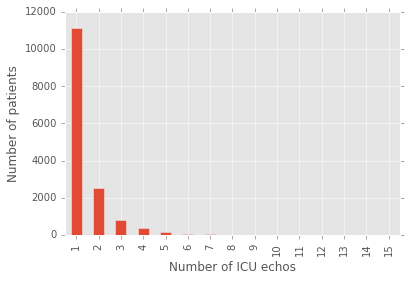

In [171]:
icu_echos['subject_id'].value_counts().value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of ICU echos')
plt.ylabel('Number of patients')

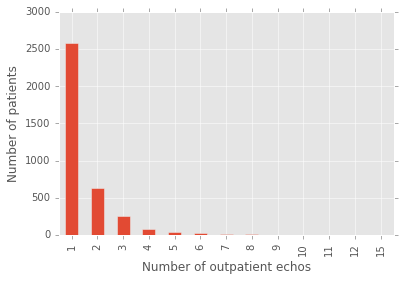

In [172]:
outpatient_echos['subject_id'].value_counts().value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of outpatient echos')
plt.ylabel('Number of patients')

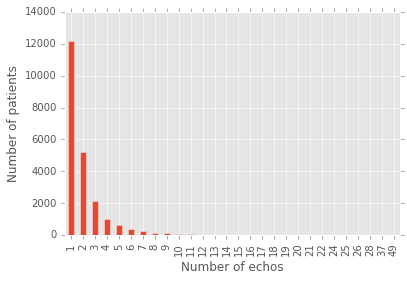

In [173]:
query = \
"""
SELECT * FROM noteevents
WHERE category = 'Echo';
"""

all_echos = pd.read_sql_query(query, con)
all_echos['subject_id'].value_counts().value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of echos')
plt.ylabel('Number of patients')

## Number of patients on dialysis

What is the best way of finding out if a patient is on dialysis? Some possibilities: 
+ Look in procedures_icd as when looking for sepsis, (inner join on hadm_id) for icd9_code 3895 (ven cath renal dialysis)
+ Look in procedureevents_mv (inner join on icustay_id) where item_id has category 'Dialysis' (metavision only)
+ Look in inputevents_cv/inputevents_mv or output_events, matching on 'Dialysis' 
    
### Look in procedures_icd

In [174]:
query = \
"""
SELECT * 
FROM d_icd_procedures dps
WHERE dps.long_title ~* '.*ialy.*';
--WHERE dps.icd9_code IN ('3895', '1255')
"""

res = pd.read_sql_query(query, con)
res.head()

,row_id,icd9_code,short_title,long_title
0,739,3927,Dialysis arteriovenostom,Arteriovenostomy for renal dialysis
1,746,3942,Revis ren dialysis shunt,Revision of arteriovenous shunt for renal dial...
2,747,3943,Remov ren dialysis shunt,Removal of arteriovenous shunt for renal dialysis
3,803,3895,Ven cath renal dialysis,Venous catheterization for renal dialysis
4,896,1255,Cyclodialysis,Cyclodialysis


In [175]:
query = \
"""
SELECT ps.hadm_id, dps.short_title
FROM procedures_icd ps
INNER JOIN d_icd_procedures dps
    ON ps.icd9_code = dps.icd9_code
WHERE dps.icd9_code = '3895';
"""

dialysis = pd.read_sql_query(query, con)
dialysis.head()

,hadm_id,short_title
0,172648,Ven cath renal dialysis
1,181171,Ven cath renal dialysis
2,162994,Ven cath renal dialysis
3,191476,Ven cath renal dialysis
4,184235,Ven cath renal dialysis


Number of hospital admissions ids that have echos and that are associated with the procedure ven cath renal dialysis

In [176]:
len(set(dialysis['hadm_id']) & set(icu_echos['hadm_id']))

917

## Number of patients on ventilator

Additionally, to find patients on ventilation: 

+ Look in cptevents ("useful for determining if certain procedures have been performed, e.g. ventilation"). Also see important considerations.
+ Note that in determining sepsis, procedures_icd is used

Note that cptevents also has a chartdate, which means that it should be possible to check, for example, if the ventilation ocurred at all during the icu_stay where the echo was done. 

In [177]:
query = \
"""
SELECT ce.description, ce.chartdate, ce.hadm_id
FROM cptevents ce
WHERE ce.description ~* '.*vent.*'
"""
vent = pd.read_sql_query(query, con)
vent.head()

,description,chartdate,hadm_id
0,VENT MGMT;SUBSQ DAYS(INVASIVE),2177-11-26,181695
1,VENT MGMT;SUBSQ DAYS(INVASIVE),2177-11-27,181695
2,VENT MGMT;SUBSQ DAYS(INVASIVE),2177-11-28,181695
3,VENT MGMT;SUBSQ DAYS(INVASIVE),2177-11-29,181695
4,VENT MGMT;SUBSQ DAYS(INVASIVE),2177-11-30,181695


Number of hospital admission IDs with ICU echos. 

In [178]:
len(set(vent['hadm_id']) & set(icu_echos['hadm_id']))

8768

## Average ICU length of stay

In [179]:
res = icu_echos.groupby('icustay_id').first()
(res['outtime'] - res['intime']).mean()

Timedelta('7 days 20:41:21.039698')

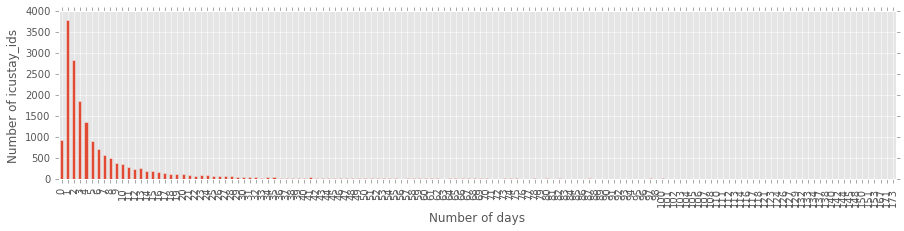

In [180]:
plt.figure(figsize = (15, 3))
(res['outtime'] - res['intime']).apply(lambda dt: dt.days).value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of days')
plt.ylabel('Number of icustay_ids')

## Mortality in ICU

For each ICU echo, count the number of instances where death occurred during that ICU stay. Note that DOD gives only the date. The question is if the death occurred before the icustay outtime. 

In [181]:
icu_echos.loc[pd.to_datetime(icu_echos['dod']) < icu_echos['outtime']].shape

(2906, 14)

In [182]:
icu_echos.loc[pd.to_datetime(icu_echos['dod']) < icu_echos['outtime']].head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,dob,dod,dischtime,this_icu,time_to_echo,age
12,185407,78041,29466,2200-05-02 16:10:00,PATIENT/TEST INFORMATION:\nIndication: Recent ...,2200-05-01 23:05:20,2200-05-03 15:26:48,275996,2121-08-31,2200-05-03,2200-05-03 12:20:00,1,0 days 17:04:40,78.0
29,111095,77997,11167,2169-04-19 11:25:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2169-03-10 20:21:03,2169-05-06 20:38:06,262941,2120-06-09,2169-05-06,2169-05-06 13:35:00,1,39 days 15:03:57,48.0
30,111095,77998,11167,2169-04-14 08:57:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2169-03-10 20:21:03,2169-05-06 20:38:06,262941,2120-06-09,2169-05-06,2169-05-06 13:35:00,1,34 days 12:35:57,48.0
42,182743,77776,164,2117-01-06 11:10:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2116-12-28 15:34:05,2117-01-16 04:01:58,218740,2034-04-26,2117-01-16,2117-01-16 03:20:00,1,8 days 19:35:55,82.0
44,154616,77645,22358,2167-07-28 15:40:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2167-07-25 17:41:43,2167-08-10 10:29:04,223519,2115-09-04,2167-08-10,2167-08-10 07:00:00,1,2 days 21:58:17,51.0


## Mortality in hospital

For each ICU echo, count the number of instances where death occurred during that hospital admission. Again, note that DOD gives only the date. 

In [183]:
icu_echos.loc[pd.to_datetime(icu_echos['dod']) < icu_echos['dischtime']].shape

(3553, 14)

In [184]:
icu_echos.loc[pd.to_datetime(icu_echos['dod']) < icu_echos['dischtime']].head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,dob,dod,dischtime,this_icu,time_to_echo,age
12,185407,78041,29466,2200-05-02 16:10:00,PATIENT/TEST INFORMATION:\nIndication: Recent ...,2200-05-01 23:05:20,2200-05-03 15:26:48,275996,2121-08-31,2200-05-03,2200-05-03 12:20:00,1,0 days 17:04:40,78.0
29,111095,77997,11167,2169-04-19 11:25:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2169-03-10 20:21:03,2169-05-06 20:38:06,262941,2120-06-09,2169-05-06,2169-05-06 13:35:00,1,39 days 15:03:57,48.0
30,111095,77998,11167,2169-04-14 08:57:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2169-03-10 20:21:03,2169-05-06 20:38:06,262941,2120-06-09,2169-05-06,2169-05-06 13:35:00,1,34 days 12:35:57,48.0
32,115026,77588,6334,2168-01-25 10:06:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2167-12-10 14:40:46,2168-02-05 17:51:20,247862,2097-09-08,2168-02-09,2168-02-09 17:47:00,1,45 days 19:25:14,70.0
33,115026,77589,6334,2168-01-18 13:29:00,PATIENT/TEST INFORMATION:\nIndication: Congest...,2167-12-10 14:40:46,2168-02-05 17:51:20,247862,2097-09-08,2168-02-09,2168-02-09 17:47:00,1,38 days 22:48:14,70.0


## 30-day mortality

For each ICU echo, count the number of instances where death occurred within 30 days of the echo. 

In [192]:
icu_echos.loc[(pd.to_datetime(icu_echos['dod']) - icu_echos['echo_time']) < pd.Timedelta(days = 30)].shape

(4087, 14)

In [193]:
icu_echos.loc[(pd.to_datetime(icu_echos['dod']) - icu_echos['echo_time']) < pd.Timedelta(days = 30)].head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,dob,dod,dischtime,this_icu,time_to_echo,age
10,180391,78037,42346,2160-12-17 10:02:00,PATIENT/TEST INFORMATION:\nIndication: Atrial ...,2160-12-16 13:47:43,2160-12-17 12:41:12,223285,2072-12-03,2160-12-27,2160-12-21 15:30:00,1,0 days 20:14:17,88.0
12,185407,78041,29466,2200-05-02 16:10:00,PATIENT/TEST INFORMATION:\nIndication: Recent ...,2200-05-01 23:05:20,2200-05-03 15:26:48,275996,2121-08-31,2200-05-03,2200-05-03 12:20:00,1,0 days 17:04:40,78.0
29,111095,77997,11167,2169-04-19 11:25:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2169-03-10 20:21:03,2169-05-06 20:38:06,262941,2120-06-09,2169-05-06,2169-05-06 13:35:00,1,39 days 15:03:57,48.0
30,111095,77998,11167,2169-04-14 08:57:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2169-03-10 20:21:03,2169-05-06 20:38:06,262941,2120-06-09,2169-05-06,2169-05-06 13:35:00,1,34 days 12:35:57,48.0
32,115026,77588,6334,2168-01-25 10:06:00,PATIENT/TEST INFORMATION:\nIndication: Endocar...,2167-12-10 14:40:46,2168-02-05 17:51:20,247862,2097-09-08,2168-02-09,2168-02-09 17:47:00,1,45 days 19:25:14,70.0


## Diagnoses for ICU admission

Diagnoses can only be joined to noteevents via hadm_id, and there are no time stamps associated, so it is unclear how to link to a specific ICU stay. I can however grab all the diagnoses associated with a hadm_id. 

In [194]:
query = \
"""
SELECT ne.hadm_id, ddg.short_title, ddg.long_title
FROM noteevents ne
INNER JOIN diagnoses_icd dg
    ON ne.hadm_id = dg.hadm_id
INNER JOIN d_icd_diagnoses ddg
    ON dg.icd9_code = ddg.icd9_code
WHERE ne.category = 'Echo'
"""

diagnoses = pd.read_sql_query(query, con)
diagnoses.head()

,hadm_id,short_title,long_title
0,124723,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...
1,124723,Posttraumatic stress dis,Posttraumatic stress disorder
2,124723,Anemia NOS,"Anemia, unspecified"
3,124723,Myoclonus,Myoclonus
4,124723,Drug abuse NEC-unspec,"Other, mixed, or unspecified drug abuse, unspe..."


In [195]:
diagnoses['short_title'].value_counts().head(n = 10)

Hypertension NOS            13747
CHF NOS                     12907
Atrial fibrillation         11929
Crnry athrscl natve vssl    11573
Acute kidney failure NOS     7671
Hyperlipidemia NEC/NOS       7288
Acute respiratry failure     6679
DMII wo cmp nt st uncntr     6477
Urin tract infection NOS     4961
Anemia NOS                   4394
Name: short_title, dtype: int64

## Number of patients carrying a diagnosis of heart failure

See diagnoses for ICU admission. From [here](http://www.icd9data.com/2012/Volume1/390-459/420-429/428/), heart failure looks like 428-. 

In [196]:
query = \
"""
SELECT ne.hadm_id, ddg.short_title, ddg.long_title, dg.icd9_code
FROM noteevents ne
INNER JOIN diagnoses_icd dg
    ON ne.hadm_id = dg.hadm_id
INNER JOIN d_icd_diagnoses ddg
    ON dg.icd9_code = ddg.icd9_code
WHERE ne.category = 'Echo' AND substring(dg.icd9_code,1,3) = '428'
"""

heartfailure = pd.read_sql_query(query, con)
heartfailure.head()

,hadm_id,short_title,long_title,icd9_code
0,100035,CHF NOS,"Congestive heart failure, unspecified",4280
1,100035,Chr systolic hrt failure,Chronic systolic heart failure,42822
2,100036,CHF NOS,"Congestive heart failure, unspecified",4280
3,100036,Ac on chr diast hrt fail,Acute on chronic diastolic heart failure,42833
4,100039,Ac/chr syst/dia hrt fail,Acute on chronic combined systolic and diastol...,42843


Number of ICU echos associated with an admission ID that has a diagnosis of heart failure

In [197]:
icu_echos.loc[icu_echos['hadm_id'].apply(lambda d: d in heartfailure['hadm_id'].unique())].shape

(8937, 14)

What makes most sense to me is to count the number of echos which were taken AFTER a diagnosis of heart failure, and so the query should be constructed by patient instead.  

## Number of people with valvular heart disease that is moderate or above

+ 424.9: Heart disease, unspecified
+ 396.9: Mitral and aortic valve diseases, unspecified

I'm not sure how to check if the disease is moderate or above? 

## Number of secondary diagnoses

Number of diagnoses associated with each hospital admission. 

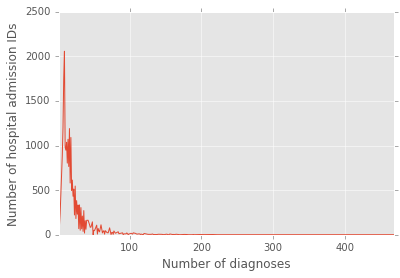

In [198]:
diagnoses['hadm_id'].value_counts().value_counts().sort_index().plot()
plt.xlabel('Number of diagnoses')
plt.ylabel('Number of hospital admission IDs')

## Distribution of ages

>DOB has been shifted for patients older than 89. The median age for the patients whose date of birth was shifted is 91.4

In [207]:
icu_echos.loc[icu_echos['age'] > 100].head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,dob,dod,dischtime,this_icu,time_to_echo,age
90,176993,78031,27163,2129-05-24 12:53:00,PATIENT/TEST INFORMATION:\nIndication: Chest p...,2129-05-23 20:04:09,2129-05-25 02:47:09,226921,1828-12-30,2129-09-03,2129-05-27 14:34:00,1,0 days 16:48:51,300.0
91,199439,78032,27163,2129-02-03 09:12:00,PATIENT/TEST INFORMATION:\nIndication: Cerebro...,2129-02-02 16:23:30,2129-02-03 17:48:18,294109,1828-12-30,2129-09-03,2129-02-09 14:00:00,1,0 days 16:48:30,300.0
154,180232,78789,13935,2104-06-02 09:23:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2104-06-02 02:35:02,2104-06-03 15:25:45,251740,1804-06-01,2108-04-13,2104-06-09 14:50:00,1,0 days 06:47:58,300.0
157,176473,78453,71878,2148-09-02 11:47:00,PATIENT/TEST INFORMATION:\nIndication: Congest...,2148-09-01 23:02:25,2148-09-04 19:59:48,234313,1847-01-24,2149-05-18,2148-09-05 17:11:00,1,0 days 12:44:35,301.0
186,171473,78607,7637,2134-07-02 10:30:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2134-06-29 21:57:07,2134-07-07 19:48:07,226005,1834-06-26,2134-07-07,2134-07-07 17:45:00,1,2 days 12:32:53,300.0


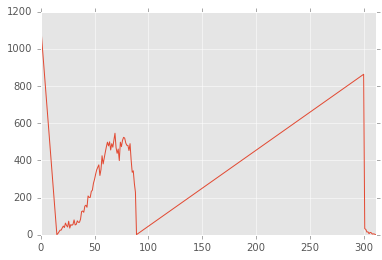

In [223]:
icu_echos['age'].value_counts().sort_index().plot()

As a basis for comparison, age at death:

In [212]:
query = \
"""
SELECT ps.subject_id, 
    extract(year from age(ps.dod, ps.dob)) AS age
FROM patients ps
LEFT JOIN noteevents ne
    ON ps.subject_id = ne.subject_id
WHERE ne.category = 'Echo' AND ps.expire_flag = 1;
"""

ages = pd.read_sql_query(query, con)
ages.head()

,subject_id,age
0,7949,51.0
1,13302,39.0
2,13302,39.0
3,26212,56.0
4,9647,85.0


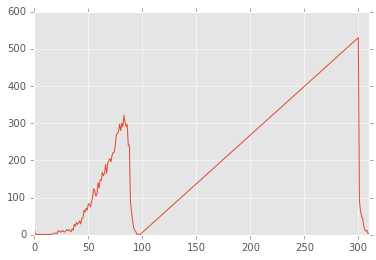

In [220]:
ages.groupby('subject_id').first()['age'].value_counts().sort_index().plot()

## Distribution of genders

Across icu echos

In [227]:
icu_echos['gender'].value_counts()

M    12578
F     9591
Name: gender, dtype: int64

Across patients who have icu echos

In [230]:
icu_echos.groupby('subject_id').first()['gender'].value_counts()

M    8674
F    6479
Name: gender, dtype: int64

## Number of patients who had a BNP or NTproBNP sent

Searching for [bnp](https://search.loinc.org/search.zul?query=bnp): 

In [250]:
query = \
"""
SELECT * FROM d_labitems
WHERE loinc_code IN ('42637-9', '30934-4', '35257-5', 
                     '47092-2', '71425-3', '77622-9', 
                     '77621-1', '33762-6', '33763-4')
"""

labs = pd.read_sql_query(query, con)
labs.head()

,row_id,itemid,label,fluid,category,loinc_code
0,164,50963,NTproBNP,Blood,Chemistry,33762-6


I only find one hit. I can however look for the number of echos associated with a hospital admission ID that is associated with a lab. Labevents also gives charttime. 

In [272]:
query = \
"""
WITH 
    d_labs AS (
    SELECT * FROM d_labitems
    WHERE loinc_code IN ('42637-9', '30934-4', '35257-5', 
                     '47092-2', '71425-3', '77622-9', 
                     '77621-1', '33762-6', '33763-4')
    ), 
    labs AS (
    SELECT le.subject_id, le.hadm_id, le.charttime, 
        dl.label, le.flag, le.valuenum, le.valueuom
    FROM labevents as le
    INNER JOIN d_labs as dl
        ON le.itemid = dl.itemid
    ),
-- parse echo report to get echo_time
    echos AS (
    SELECT hadm_id, row_id, subject_id, text,
    -- timestamp for echo
    to_timestamp(
        regexp_replace(regexp_replace(regexp_replace(
            substring(text from 'Date/Time:.*?\n'), 
            'Date/Time: ...', ''), '... at', ''), '\n', ''), 
        'YYYY-MM-DD HH24:MI')::timestamp without time zone AS echo_time  
    FROM noteevents
    WHERE category = 'Echo'), 
-- merge with icustays, get icustay timestamps, and calculate timedeltas wrt echo_time    
    this_echo AS (
    SELECT ec.hadm_id, ec.row_id, ec.subject_id, ec.echo_time, ec.text,
        ie.intime, ie.outtime, ie.icustay_id,
        lb.label, lb.charttime, lb.flag, lb.valuenum, lb.valueuom,
        CASE 
        WHEN ((ec.echo_time > ie.intime) AND 
            (ec.echo_time < ie.outtime)) 
        THEN 1 ELSE 0 END AS this_icu, 
        ec.echo_time - ie.intime AS time_to_echo,
        -- age in years
        extract(year from age(ec.echo_time::date, ps.dob)) AS age 
    FROM echos ec
    INNER JOIN icustays ie
        ON ie.hadm_id = ec.hadm_id
    INNER JOIN patients ps
        ON ie.subject_id = ps.subject_id
    INNER JOIN admissions am
        ON ie.hadm_id = am.hadm_id
    LEFT JOIN labs lb
        ON ie.hadm_id = lb.hadm_id)
SELECT * 
FROM this_echo
WHERE this_icu = 1
"""

bnp = pd.read_sql_query(query, con)
bnp.head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,label,charttime,flag,valuenum,valueuom,this_icu,time_to_echo,age
0,182383,65074,107,2121-12-01 15:18:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2121-11-30 19:24:56,2121-12-01 21:20:57,252542,NTproBNP,2121-11-30 16:10:00,abnormal,3760.0,pg/mL,1,0 days 19:53:04,69.0
1,103002,99168,222,2143-02-18 08:41:00,PATIENT/TEST INFORMATION:\nIndication: Dyspnea...,2143-02-16 12:59:06,2143-02-18 18:22:01,256144,NTproBNP,2143-02-16 14:01:00,abnormal,3075.0,pg/mL,1,1 days 19:41:54,69.0
2,191151,79603,236,2139-03-21 10:49:00,PATIENT/TEST INFORMATION:\nIndication: Coronar...,2139-03-20 19:43:20,2139-03-22 15:51:23,227008,NTproBNP,2139-03-27 04:42:00,abnormal,9625.0,pg/mL,1,0 days 15:05:40,57.0
3,191151,79603,236,2139-03-21 10:49:00,PATIENT/TEST INFORMATION:\nIndication: Coronar...,2139-03-20 19:43:20,2139-03-22 15:51:23,227008,NTproBNP,2139-02-24 08:05:00,abnormal,14147.0,pg/mL,1,0 days 15:05:40,57.0
4,191151,79603,236,2139-03-21 10:49:00,PATIENT/TEST INFORMATION:\nIndication: Coronar...,2139-03-20 19:43:20,2139-03-22 15:51:23,227008,NTproBNP,2139-02-25 06:24:00,abnormal,12336.0,pg/mL,1,0 days 15:05:40,57.0


Number of hospital admissions with at least 1 NTproBNP lab:

In [280]:
bnp.sort_values('label').groupby('hadm_id').first()['label'].value_counts(dropna = False)

NaN         14633
NTproBNP     2329
Name: label, dtype: int64

## Number of patients who had a troponin-I or troponin-T sent

In [281]:
query = \
"""
SELECT * FROM d_labitems
WHERE loinc_code IN ('67151-1', '16255-2', '42757-5', 
                     '10839-9', '49563-0', '76399-5', 
                     '48425-3', '6597-9', '6598-7', 
                     '48426-1', '33204-9')
"""

labs = pd.read_sql_query(query, con)
labs.head()

,row_id,itemid,label,fluid,category,loinc_code
0,202,51002,Troponin I,Blood,Chemistry,10839-9
1,203,51003,Troponin T,Blood,Chemistry,6598-7


In [283]:
query = \
"""
WITH 
    d_labs AS (
    SELECT * FROM d_labitems
    WHERE loinc_code IN ('67151-1', '16255-2', '42757-5', 
                         '10839-9', '49563-0', '76399-5', 
                         '48425-3', '6597-9', '6598-7', 
                         '48426-1', '33204-9')
    ),
    labs AS (
    SELECT le.subject_id, le.hadm_id, le.charttime, 
        dl.label, le.flag, le.valuenum, le.valueuom
    FROM labevents as le
    INNER JOIN d_labs as dl
        ON le.itemid = dl.itemid
    ),
-- parse echo report to get echo_time
    echos AS (
    SELECT hadm_id, row_id, subject_id, text,
    -- timestamp for echo
    to_timestamp(
        regexp_replace(regexp_replace(regexp_replace(
            substring(text from 'Date/Time:.*?\n'), 
            'Date/Time: ...', ''), '... at', ''), '\n', ''), 
        'YYYY-MM-DD HH24:MI')::timestamp without time zone AS echo_time  
    FROM noteevents
    WHERE category = 'Echo'), 
-- merge with icustays, get icustay timestamps, and calculate timedeltas wrt echo_time    
    this_echo AS (
    SELECT ec.hadm_id, ec.row_id, ec.subject_id, ec.echo_time, ec.text,
        ie.intime, ie.outtime, ie.icustay_id,
        lb.label, lb.charttime, lb.flag, lb.valuenum, lb.valueuom,
        CASE 
        WHEN ((ec.echo_time > ie.intime) AND 
            (ec.echo_time < ie.outtime)) 
        THEN 1 ELSE 0 END AS this_icu, 
        ec.echo_time - ie.intime AS time_to_echo,
        -- age in years
        extract(year from age(ec.echo_time::date, ps.dob)) AS age 
    FROM echos ec
    INNER JOIN icustays ie
        ON ie.hadm_id = ec.hadm_id
    INNER JOIN patients ps
        ON ie.subject_id = ps.subject_id
    INNER JOIN admissions am
        ON ie.hadm_id = am.hadm_id
    LEFT JOIN labs lb
        ON ie.hadm_id = lb.hadm_id)
SELECT * 
FROM this_echo
WHERE this_icu = 1
"""

troponin = pd.read_sql_query(query, con)
troponin.head()

,hadm_id,row_id,subject_id,echo_time,text,intime,outtime,icustay_id,label,charttime,flag,valuenum,valueuom,this_icu,time_to_echo,age
0,129635,78499,25,2160-11-02 11:16:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2160-11-02 03:16:23,2160-11-05 16:23:27,203487,Troponin T,2160-11-02 01:05:00,abnormal,0.11,ng/ml,1,07:59:37,58.0
1,129635,78499,25,2160-11-02 11:16:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2160-11-02 03:16:23,2160-11-05 16:23:27,203487,Troponin T,2160-11-02 08:55:00,abnormal,0.42,ng/ml,1,07:59:37,58.0
2,119203,77268,42,2116-04-27 10:14:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2116-04-26 18:59:35,2116-04-28 16:39:05,210828,Troponin T,2116-04-26 20:00:00,None,NaN,ng/mL,1,15:14:25,61.0
3,119203,77268,42,2116-04-27 10:14:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2116-04-26 18:59:35,2116-04-28 16:39:05,210828,Troponin T,2116-04-27 05:00:00,None,NaN,ng/mL,1,15:14:25,61.0
4,129635,78499,25,2160-11-02 11:16:00,PATIENT/TEST INFORMATION:\nIndication: Left ve...,2160-11-02 03:16:23,2160-11-05 16:23:27,203487,Troponin T,2160-11-02 17:05:00,abnormal,1.08,ng/ml,1,07:59:37,58.0


In [284]:
troponin.sort_values('label').groupby('hadm_id').first()['label'].value_counts(dropna = False)

Troponin T    9632
NaN           6138
Troponin I    1192
Name: label, dtype: int64

## Baseline Creatinine (Cr) prior to the admission

## ICU Cr on the day of the echo 

## Cr measurement post ICU discharge

In [291]:
query = \
"""
SELECT * FROM d_items;
"""

items = pd.read_sql_query(query, con)
items.head()

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,457,497,Patient controlled analgesia (PCA) [Inject],None,carevue,chartevents,None,None,None,None
1,458,498,PCA Lockout (Min),None,carevue,chartevents,None,None,None,None
2,459,499,PCA Medication,None,carevue,chartevents,None,None,None,None
3,460,500,PCA Total Dose,None,carevue,chartevents,None,None,None,None
4,461,501,PCV Exh Vt (Obser),None,carevue,chartevents,None,None,None,None


In [288]:
items.loc[items['label'].apply(lambda l: 'reatinine' in l if l else False)]

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
1529,710,791,Creatinine (0-1.3),None,carevue,chartevents,Chemistry,None,None,None
2460,1914,5811,urine creatinine,None,carevue,chartevents,None,None,None,None
2687,2871,3750,Creatinine (0-0.7),None,carevue,chartevents,Chemistry,None,None,None
2793,2977,1525,Creatinine,None,carevue,chartevents,Chemistry,None,None,None
9674,14682,227005,Creatinine_ApacheIV,Creatinine_ApacheIV,metavision,chartevents,Scores - APACHE IV (2),None,Numeric,None
11485,12698,220615,Creatinine,Creatinine,metavision,chartevents,Labs,None,Numeric,None
12476,14512,226751,CreatinineApacheIIScore,CreatinineApacheIIScore,metavision,chartevents,Scores - APACHE II,None,Numeric,None
12477,14513,226752,CreatinineApacheIIValue,CreatinineApacheIIValue,metavision,chartevents,Scores - APACHE II,None,Numeric,None


In [292]:
items.loc[items['label'].apply(lambda l: 'iagn' in l if l else False)]

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
774,1151,917,Diagnosis/op,None,carevue,chartevents,None,None,None,None
9324,14665,226987,APACHE IV diagnosis,APACHE IV diagnosis,metavision,chartevents,Scores - APACHE IV,None,Text,None
9487,14663,226985,APACHE IV diagnosis choice 1,APACHE IV diagnosis choice 1,metavision,chartevents,Scores - APACHE IV,None,Text,None
9488,14664,226986,APACHE IV diagnosis choice 2,APACHE IV diagnosis choice 2,metavision,chartevents,Scores - APACHE IV,None,Text,None
9936,14857,227342,Secondary diagnosis,Secondary diagnosis,metavision,chartevents,Restraint/Support Systems,None,Text,None
11983,15299,228106,NonOperative Diagnoses,NonOperative Diagnoses,metavision,chartevents,ApacheII Parameters,None,Text,None
11984,15300,228107,Elective Postoperative Diagnoses,Elective Postoperative Diagnoses,metavision,chartevents,ApacheII Parameters,None,Text,None
11985,15301,228108,Emergency Postoperative Diagnoses,Emergency Postoperative Diagnoses,metavision,chartevents,ApacheII Parameters,None,Text,None
11986,15302,228109,APACHE IV diagnoses,APACHE IV diagnoses,metavision,chartevents,ApacheIV Parameters,None,Text,None
11987,15303,228110,APACHE IV diagnoses-2,APACHE IV diagnoses-2,metavision,chartevents,ApacheIV Parameters,None,Text,None


In [293]:
items.loc[items['label'].apply(lambda l: 'BNP' in l if l else False)]

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
4323,4600,7294,BNP,None,carevue,chartevents,None,None,None,None
10078,14760,227446,Brain Natiuretic Peptide (BNP),Brain Natiuretic Peptide (BNP),metavision,chartevents,Labs,None,Numeric with tag,None
10505,14079,225622,ZBrain Natiuretic Peptide (BNP),ZBrain Natiuretic Peptide (BNP),metavision,chartevents,Labs,None,Numeric,None
